<a href="https://colab.research.google.com/github/LatiefDataVisionary/multivariate-analysis-college-task/blob/main/src/KMeans_w11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [23]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

**1. Load Dataset**

In [24]:
path = kagglehub.dataset_download('whenamancodes/predict-diabities')
print(f"Konten/dataset dari downloaded directory '{path}':")
for item in os.listdir(path):
    print(item)

csv_file_path = os.path.join(path, 'diabetes.csv')

Konten/dataset dari downloaded directory '/kaggle/input/predict-diabities':
diabetes.csv


In [25]:
df = pd.read_csv(csv_file_path, usecols=['BloodPressure', 'Age'])
df.head()

,BloodPressure,Age
0,72,50
1,66,31
2,64,32
3,66,21
4,40,33


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   BloodPressure  768 non-null    int64
 1   Age            768 non-null    int64
dtypes: int64(2)
memory usage: 12.1 KB


In [28]:
df.describe()

,BloodPressure,Age
count,768.000000,768.000000
mean,69.105469,33.240885
std,19.355807,11.760232
min,0.000000,21.000000
25%,62.000000,24.000000
50%,72.000000,29.000000
75%,80.000000,41.000000
max,122.000000,81.000000


**2. Data Preprocessing**

Cek missing Values

In [29]:
df.isnull().sum()

,0
BloodPressure,0
Age,0


Standarisasi data

In [30]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['BloodPressure', 'Age']])

**3. Menentukan Jumlah Klaster Optimal (Elbow Metthod) secara otomatis**

  - Menghitung SSE (Sum of Squared Errors) untuk k=1 hingga 7
  - Mendeteksi titik siku secara otomatis

In [36]:
sse = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Deteksi siku otomatis berdasarkan penurunan SSE
k_diff = np.diff(sse)
k_optimal = np.argmax(k_diff < 0.5 * k_diff[0]) + 2 if any(k_diff < 0.5 * k_diff[0]) else 3

**4. K-Means clustering**

  - Membuat model dengan k optimal
  - Menambahkan label klaster ke dataset

In [32]:
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_data)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

**5. Menghitung statistik per klaster**

- Jumlah pasien, rata-rata usia, rata-rata tekanan darah

In [33]:
cluster_stats = df.groupby('Cluster').agg(
    Patients=('Age', 'count'),
    Avg_Age=('Age', 'mean'),
    Avg_BP=('BloodPressure', 'mean'),
    BP_Std=('BloodPressure', 'std')
).reset_index()

**6. Visualize results**


  - Scatter plot dengan warna berbeda per klaster
  - Menampilkan posisi centroid
  - Garis referensi tekanan darah

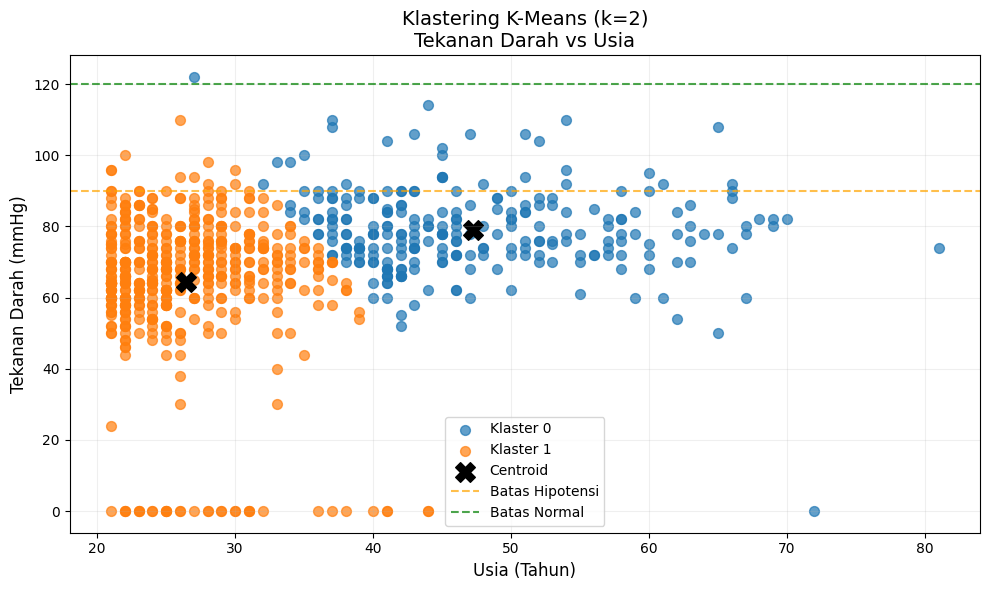

In [38]:
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i in range(k_optimal):
    cluster_data = df[df['Cluster'] == i]
    plt.scatter(cluster_data['Age'], cluster_data['BloodPressure'],
                color=colors[i], alpha=0.7, s=50, label=f'Klaster {i}')

# Plot centroid
plt.scatter(centroids[:, 1], centroids[:, 0], marker='X', s=200,
            color='black', label='Centroid')

# Garis referensi medis
plt.axhline(90, color='orange', linestyle='--', alpha=0.7, label='Batas Hipotensi')
plt.axhline(120, color='green', linestyle='--', alpha=0.7, label='Batas Normal')

# Format visualisasi
plt.title(f'Klastering K-Means (k={k_optimal})\nTekanan Darah vs Usia', fontsize=14)
plt.xlabel('Usia (Tahun)', fontsize=12)
plt.ylabel('Tekanan Darah (mmHg)', fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('hasil_klastering.png', dpi=300)

**7. Laporan Hasil**


In [42]:
print("="*50)
print(f"{'ANALISIS KLASTERING K-MEANS':^50}")
print("="*50)
print(f"{'Jumlah klaster optimal:':<25} {k_optimal}")
print(f"{'Total pasien:':<25} {len(df)}")
print(f"{'Skor Silhouette:':<25} {silhouette_score(scaled_data, df['Cluster']):.3f}")
print("\n" + "-"*50)
print(f"{'STATISTIK PER KLASTER':^50}")
print("-"*50)
print(cluster_stats.round(1).to_string(index=False))
print("\n" + "-"*50)
print(f"{'INTERPRETASI MEDIS':^50}")
print("-"*50)

# Interpretasi hasil berdasarkan standar medis
for i in range(k_optimal):
    stats = cluster_stats[cluster_stats['Cluster'] == i].iloc[0]

    # Kategorisasi tekanan darah
    if stats['Avg_BP'] < 90:
        status_td = "Hipotensi"
    elif stats['Avg_BP'] < 120:
        status_td = "Normal"
    elif stats['Avg_BP'] < 130:
        status_td = "Pra-hipertensi"
    else:
        status_td = "Hipertensi"

    # Kategorisasi kelompok usia
    if stats['Avg_Age'] < 30:
        kelompok_usia = "Muda"
    elif stats['Avg_Age'] < 50:
        kelompok_usia = "Dewasa"
    else:
        kelompok_usia = "Lanjut Usia"

    print(f"Klaster {i} ({int(stats['Patients'])} pasien):")
    print(f"  - Profil khas: Pasien {kelompok_usia} dengan {status_td}")
    print(f"  - Rerata Usia: {stats['Avg_Age']:.1f} tahun | Rerata Tekanan darah: {stats['Avg_BP']:.1f} mmHg")

           ANALISIS KLASTERING K-MEANS            
Jumlah klaster optimal:   2
Total pasien:             768
Skor Silhouette:          0.447

--------------------------------------------------
              STATISTIK PER KLASTER               
--------------------------------------------------
 Cluster  Patients  Avg_Age  Avg_BP  BP_Std
       0       253     47.2    78.9    12.2
       1       515     26.4    64.3    20.4

--------------------------------------------------
                INTERPRETASI MEDIS                
--------------------------------------------------
Klaster 0 (253 pasien):
  - Profil khas: Pasien Dewasa dengan Hipotensi
  - Rerata Usia: 47.2 tahun | Rerata Tekanan darah: 78.9 mmHg
Klaster 1 (515 pasien):
  - Profil khas: Pasien Muda dengan Hipotensi
  - Rerata Usia: 26.4 tahun | Rerata Tekanan darah: 64.3 mmHg


**8. Menyimpan hasil**

In [ ]:
df.to_excel("hasil_klastering.xlsx", index=False)
print("\n" + "="*50)
print(f"Hasil disimpan ke hasil_klastering.xlsx")
print(f"Visualisasi disimpan ke hasil_klastering.png")